In [688]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from sklearn.model_selection import KFold
from itertools import product
from cup_helpers import SEED
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from cup_helpers import CV
from torch.optim.lr_scheduler import StepLR


ModuleNotFoundError: No module named 'torch.optim.lr_scheduler.StepLR'; 'torch.optim.lr_scheduler' is not a package

In [671]:
INPUT_SIZE = 10
OUTPUT_SIZE = 3

Create reproducible results

In [672]:
torch.manual_seed(SEED)
np.random.seed(SEED)
gen = torch.Generator().manual_seed(SEED)


In [673]:
# Datasets Path
TR_PATH = "./data/ML-CUP23-TR.csv"
TS_PATH = "./data/ML-CUP23-TS.csv"

In [674]:

def plot_graph(train_losses,losses,epochs,title):
    num_epochs = list(range(0, epochs))  
    print(len(num_epochs))
    print((train_losses))
    print((losses))
    # Plotting
    plt.plot(num_epochs, train_losses, label=' Training Loss ')
    plt.plot(num_epochs, losses, label=title+' Loss')

    plt.title('Training and '+title+' Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [675]:
class Net(nn.Module):
  def __init__(self, input_size,layers_size):
    super().__init__()
    self.layers = nn.ModuleList()
    for layer_size in layers_size:
      self.layers.append(nn.Linear(input_size,layer_size))
      input_size = layer_size

  def forward(self, x):
    for i, layer in enumerate(self.layers):
            if i != (len(self.layers) - 1):
              # Apply the layer and a ReLU activation
              x = torch.relu((layer(x)))
            else:
              x = layer(x)
    return x


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [676]:
def read_ds(path,split):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  data = pd.read_csv(path, dtype=object, delimiter=",", header=None, skiprows=1, names=["id", "INPUT_0", "INPUT_1", "INPUT_2", "INPUT_3", "INPUT_4", "INPUT_5", "INPUT_6", "INPUT_7", "INPUT_8", "INPUT_9", "TARGET_x", "TARGET_y", "TARGET_z"])
  y = data.drop(["id","INPUT_0", "INPUT_1", "INPUT_2", "INPUT_3", "INPUT_4", "INPUT_5", "INPUT_6", "INPUT_7", "INPUT_8", "INPUT_9"], axis=1)
  X = data.drop(["id","TARGET_x", "TARGET_y", "TARGET_z"], axis=1).astype(float).to_numpy()

  y = y.astype(float).to_numpy()
  
  if split == True:
    # Train/internal test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    return (np.concatenate((y_train, X_train), axis=1),np.concatenate((y_test, X_test), axis=1))
  else:
    return (np.concatenate((y, X), axis=1))

In [677]:
dataset_train,dataset_internal_test = read_ds(TR_PATH,True)

In [678]:
dataset_train[0]

array([-2.1704154e+00, -7.3649310e+01,  9.4287815e+00,  8.6179230e-02,
       -9.8935485e-01,  9.1387004e-01,  5.2771106e-02,  9.8712380e-01,
        9.9955016e-01,  8.5003810e-01, -9.1003710e-01, -7.2887754e-01,
        4.4358963e-01])

In [679]:
class ToleranceStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_training_loss = np.inf

  def tol_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.patience:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
    
    return False

In [680]:
def Padding(validation_losses_fold,train_losses_fold):
    max_epochs = max(map(len, validation_losses_fold))

    for validation_loss_arr in validation_losses_fold:
        while len(validation_loss_arr) < max_epochs:
            validation_loss_arr.append(validation_loss_arr[-1])

    for train_loss_arr in train_losses_fold:
      while len(train_loss_arr) < max_epochs:
            train_loss_arr.append(train_loss_arr[-1])

    print(len(validation_losses_fold))
    return validation_losses_fold,train_losses_fold

In [681]:
def Mean(validation_avg_loss_fold,train_losses_fold):
    max_epochs = max(map(len, validation_avg_loss_fold))
    validation_avg_loss = []
    train_avg_loss = []
    
    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(validation_avg_loss_fold)):
            temp_loss += validation_avg_loss_fold[j][i]
        validation_avg_loss.append(temp_loss)

    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(train_losses_fold)):
            temp_loss += train_losses_fold[j][i]
        train_avg_loss.append(temp_loss)
    
    return validation_avg_loss,train_avg_loss

In [682]:
def fit_model(input_size,layers_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, layers_size)
    network.apply(reset_weights) #reset weights with random initialization

    # Use the GPU, if possible
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
        network = nn.DataParallel(network)
    network.to(device)

    optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    tolerance_stopper = ToleranceStopper(patience=40, min_delta=1e-5)

    train_MEE_folds = []
    test_MEE_folds = []

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0
      train_MEE = 0.0

      # Set current loss and accuracy value for test
      test_loss = 0.0
      test_MEE = 0.0
     

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, OUTPUT_SIZE:].to(torch.float32)
        targets = data[:, :OUTPUT_SIZE].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()

        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)
        #caluclate MEE for this batch pow(2), sum(axis = 1), sqrt(), sum()
        train_MEE += float((outputs-targets).pow(2).sum(1).sqrt().sum())

      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler)    
      print("TRAIN ERROR MSE:",epoch_train_loss)

      train_MEE = train_MEE / len(trainloader.sampler) 
      train_MEE_folds.append(train_MEE)
      print("TRAIN ERROR MEE:",train_MEE_folds) 
      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, OUTPUT_SIZE:].to(torch.float32)
          targets = data[:, :OUTPUT_SIZE].to(torch.float32)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)
          test_MEE += float((outputs-targets).pow(2).sum(1).sqrt().sum())

        epoch_test_loss = test_loss / len(testloader.sampler)    
        print("TEST ERROR MSE:",epoch_test_loss)
     
        test_MEE = test_MEE / len(trainloader.sampler) 
        test_MEE_folds.append(test_MEE)

        if tolerance_stopper.tol_stop(epoch_test_loss):
          print("Early stopping: ",epoch)
          break

    plot_graph(train_MEE_folds,test_MEE_folds,epoch+1,"test")
    return network


In [683]:
def k_fold_model(input_size,layers_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader,lr_decay,lr_step_size):
    
    # Init the neural network 
    network = Net(input_size, layers_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_decay)

    tolerance_stopper = ToleranceStopper(patience=30, min_delta=1e-5)

    train_MEE_folds = []
    validation_MEE_folds = []
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      train_loss = 0.0

      #Set current MEE metric
      train_MEE = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, OUTPUT_SIZE:].to(torch.float32)
        targets = data[:, :OUTPUT_SIZE].to(torch.float32)
        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()

        
        # Perform learning decay step
        scheduler.step()

        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        if np.isnan(train_loss):
          print("Train loss is Nan, stopped this fold")
          break

        #caluclate MEE for this batch pow(2), sum(axis = 1), sqrt(), sum()
        train_MEE += float((outputs-targets).pow(2).sum(1).sqrt().sum())

      avg_train_loss = train_loss / len(trainloader.sampler)    
      print("TRAIN ERROR MSE:",avg_train_loss) 


      train_MEE = train_MEE / len(trainloader.sampler) 
      train_MEE_folds.append(train_MEE)
      


      # Evaluationfor this fold
      valid_loss = 0.0 
      val_MEE = 0.0

      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, OUTPUT_SIZE:].to(torch.float32)
          targets = data[:, :OUTPUT_SIZE].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)
          val_MEE += float((outputs-targets).pow(2).sum(1).sqrt().sum())

          if np.isnan(val_MEE):
            print("validation loss is Nan, stopped this fold")
            break

        avg_valid_loss = valid_loss / len(validationloader.sampler) #used to find the best parameters of the model
        print("VALIDATION ERROR MSE:",avg_valid_loss)
        val_MEE = val_MEE / len(validationloader.sampler)
        validation_MEE_folds.append(val_MEE)
        
        # Early stopping
        if tolerance_stopper.tol_stop(avg_valid_loss):
          print("Early stopping:", epoch)
          break
        # Print validation results
        #print(f'Validation loss: {avg_valid_loss:.4f}')


    return avg_valid_loss,avg_train_loss,validation_MEE_folds,train_MEE_folds


In [684]:
def execute_folds(kfold,dataset,batch_size,input_size, layers_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay):
    
    validation_avg_loss_fold = 0
    train_avg_loss_fold = 0
    validation_MEE_fold = []
    train_MEE_fold = []
    num_iterations = 0
    current_config = {
        'input_size': input_size,
        'layers_size': layers_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum': momentum,
        'opt': opt,
        'weight_decay': weight_decay,
        "batch_size":batch_size,
        "loss_function":loss_function
    }
    print(current_config)
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):
        
        
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 

        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss,train_loss,validation_MEE,train_MEE = k_fold_model(learning_rate=learning_rate,epochs=epochs,layers_size=layers_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader)   
        validation_avg_loss_fold  += validation_loss
        train_avg_loss_fold += train_loss
        validation_MEE_fold.append(validation_MEE)
        train_MEE_fold.append(train_MEE)

        num_iterations += 1


    #validation average over all folds
    validation_avg_loss_fold /= num_iterations
    
    validation_MEE_fold,train_MEE_fold = Padding(validation_MEE_fold,train_MEE_fold)

    validation_MEE_mean, train_MEE_mean = Mean(validation_MEE_fold, train_MEE_fold)
    
   # plot_graph(train_MEE_mean,validation_MEE_mean,len(validation_MEE_fold),"validation")


    return (validation_avg_loss_fold,train_avg_loss_fold,current_config)

function that executes the folds for each combination of parameters

In [685]:


def dogridsearch(dataset_train_part,params_grid,input_size):
    
    dataset = dataset_train_part
    # Set fixed random number seed
    loss_function = nn.MSELoss()

    # Define the K-fold Cross Validator
    kfold = CV 
    
    # K-fold Cross Validation model evaluation
    best_params = None

    actual_it = 0
    total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["layers_size"]) \
          * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"])


    configurations = []

    for epochs, opt, layers_size, learning_rate, batch_size, weight_decay, momentum in product(params_grid["epochs"],params_grid["optimizer"], 
                                                                                               params_grid["layers_size"], params_grid["learning_rate"], 
                                                                                               params_grid["batch_size"], params_grid["weight_decay"], 
                                                                                               params_grid["momentum"]):
        #print the actual percentage of the grid search
        print(f'Actual iter {(actual_it/total_iterations)*100}%')

        (validation_avg_loss_fold,train_avg_loss_fold,current_config) = execute_folds(kfold=kfold,dataset=dataset,learning_rate=learning_rate,epochs=epochs,layers_size=layers_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                        ,opt=opt,weight_decay=weight_decay,batch_size=batch_size)


        configurations.append((validation_avg_loss_fold, train_avg_loss_fold,current_config))
        
        actual_it += 1


    #best 
    for conf_val in configurations:
        if best_params is None or conf_val[0] < best_params[0]:
                current_config = conf_val[2]
                best_params = (conf_val[0],conf_val[1]
                ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['layers_size'],current_config['momentum'],current_config['opt'],
                current_config['weight_decay'],
                current_config['batch_size'])

    return best_params

test the created model and plot training/test error

In [686]:
def train_test_model(dataset_train_part,dataset_test_part,best_params):
    train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

    trainloader = torch.utils.data.DataLoader(
                        dataset_train_part, 
                        batch_size=best_params[9], sampler=train_subsampler)

    test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
    testloader = torch.utils.data.DataLoader(
                        dataset_test_part, 
                        batch_size=best_params[9], sampler=test_subsampler)

    best_net = fit_model(learning_rate=best_params[2],epochs=best_params[3],layers_size=best_params[5],input_size=INPUT_SIZE,loss_function=best_params[4],
                        momentum=best_params[6],opt=best_params[7],trainloader=trainloader,weight_decay=best_params[8],testloader=testloader)   
    return best_net

In [687]:

params_grid_general = {
    "layers_size": [[3, 4, OUTPUT_SIZE]],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}

params_grid = {
    "layers_size": [[50, 25, OUTPUT_SIZE]],
    "learning_rate": [0.01],
    "batch_size": [5],
    "weight_decay": [0.1,0,0.2,0.3],
    "momentum": [0.1],
    "epochs":[100],
    "optimizer":[torch.optim.SGD],
}
    

dataset = dataset_train

best_params = dogridsearch(dataset_train_part=dataset,params_grid=params_grid,input_size=INPUT_SIZE)
        



Actual iter 0.0%
{'input_size': 10, 'layers_size': [50, 25, 3], 'learning_rate': 0.01, 'epochs': 100, 'momentum': 0.1, 'opt': <class 'torch.optim.sgd.SGD'>, 'weight_decay': 0.1, 'batch_size': 5, 'loss_function': MSELoss()}
Starting epoch 1
TRAIN ERROR MSE: 422.8435889184475
VALIDATION ERROR MSE: 489.0986189842224
Starting epoch 2
TRAIN ERROR MSE: 389.01419749855995
VALIDATION ERROR MSE: 466.0156111717224
Starting epoch 3
TRAIN ERROR MSE: 562.4272825717926
VALIDATION ERROR MSE: 18329.528825759888
Starting epoch 4
TRAIN ERROR MSE: nan
VALIDATION ERROR MSE: nan
Starting epoch 5
TRAIN ERROR MSE: nan
VALIDATION ERROR MSE: nan
Starting epoch 6
TRAIN ERROR MSE: nan
VALIDATION ERROR MSE: nan
Starting epoch 7
TRAIN ERROR MSE: nan
VALIDATION ERROR MSE: nan
Starting epoch 8
TRAIN ERROR MSE: nan
VALIDATION ERROR MSE: nan
Starting epoch 9
TRAIN ERROR MSE: nan
VALIDATION ERROR MSE: nan
Starting epoch 10
TRAIN ERROR MSE: nan
VALIDATION ERROR MSE: nan
Starting epoch 11
TRAIN ERROR MSE: nan
VALIDATION 

Best hidden size: [15, 5, 3] 
Best learning rate: 0.2 
Best batch size: 5 
Best weight decay: 0 
Best momentum: 0.5

In [668]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: [15, 5, 3] 
Best learning rate: 0.2 
Best batch size: 5 
Best weight decay: 0 
Best momentum: 0.5
(565.4770458221435, 2805.421184659004, 0.2, 10, MSELoss(), [15, 5, 3], 0.5, <class 'torch.optim.sgd.SGD'>, 0, 5)


Starting epoch 1
TRAIN ERROR MSE: 999394.3691210747
TRAIN ERROR MEE: [283.3987105178833]
TEST ERROR MSE: 560.6776416778564
Starting epoch 2
TRAIN ERROR MSE: 562.4424145698547
TRAIN ERROR MEE: [283.3987105178833, 39.16054058074951]
TEST ERROR MSE: 555.2044052124023
Starting epoch 3
TRAIN ERROR MSE: 560.5235510826111
TRAIN ERROR MEE: [283.3987105178833, 39.16054058074951, 39.0597021484375]
TEST ERROR MSE: 552.3287750244141
Starting epoch 4
TRAIN ERROR MSE: 563.2004023551941
TRAIN ERROR MEE: [283.3987105178833, 39.16054058074951, 39.0597021484375, 39.113149852752684]
TEST ERROR MSE: 571.1325721740723
Starting epoch 5
TRAIN ERROR MSE: 566.9540798187256
TRAIN ERROR MEE: [283.3987105178833, 39.16054058074951, 39.0597021484375, 39.113149852752684, 39.25006456375122]
TEST ERROR MSE: 564.4882987976074
Starting epoch 6
TRAIN ERROR MSE: 563.6074480056762
TRAIN ERROR MEE: [283.3987105178833, 39.16054058074951, 39.0597021484375, 39.113149852752684, 39.25006456375122, 39.16606872558594]
TEST ERROR M

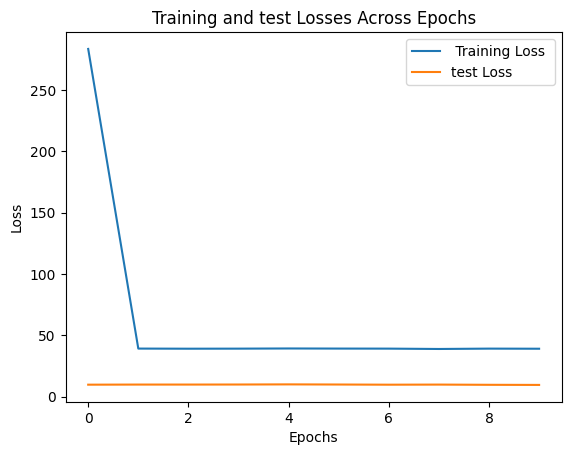

In [669]:
best_net = train_test_model(dataset_train_part=dataset_train,dataset_test_part=dataset_internal_test,best_params=best_params)  